In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d dedeikhsandwisaputra/rice-leafs-disease-dataset

 99% 293M/294M [00:02<00:00, 207MB/s]
100% 294M/294M [00:02<00:00, 136MB/s]


In [ ]:
!unzip /content/rice-leafs-disease-dataset.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model
import itertools
import os
import glob as gb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
batch_size = 32
num_epochs = 30
num_classes = 6

In [ ]:
train_data_path = '/content/RiceLeafsDisease/train'
val_data_path = '/content/RiceLeafsDisease/validation'


Train_Gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

Val_gen = ImageDataGenerator(
    rescale=1./255
)

train_generator = Train_Gen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)


validation_generator = Val_gen.flow_from_directory(
    val_data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)


Found 2100 images belonging to 6 classes.
Found 528 images belonging to 6 classes.


In [ ]:
train_generator.class_indices

{'bacterial_leaf_blight': 0,
 'brown_spot': 1,
 'healthy': 2,
 'leaf_blast': 3,
 'leaf_scald': 4,
 'narrow_brown_spot': 5}

In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

['bacterial_leaf_blight',
 'brown_spot',
 'healthy',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

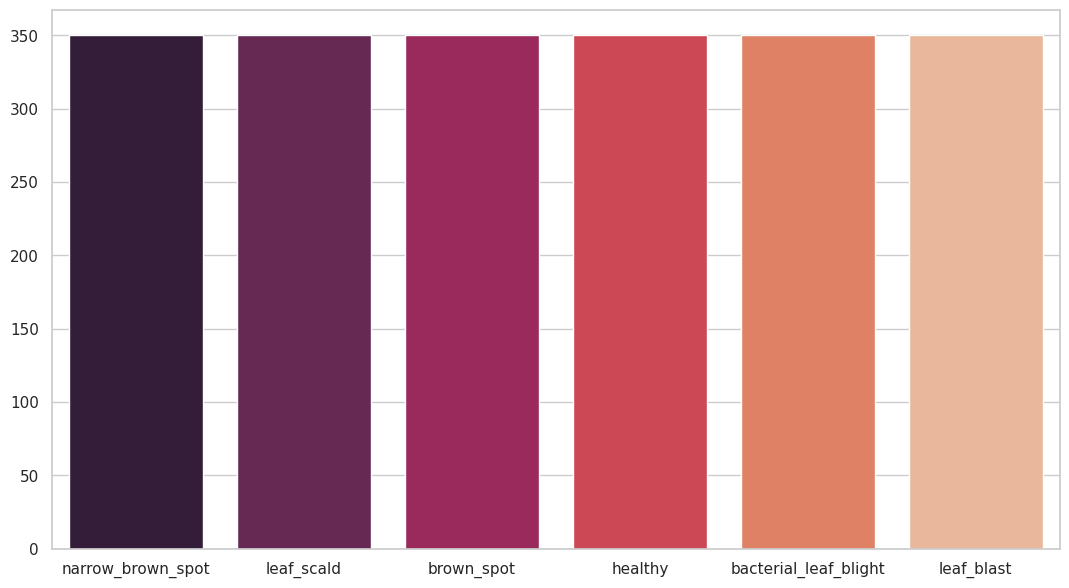

In [ ]:
import os
import glob as gb
sns.set_theme(style="whitegrid")
Data_imbalance = []
x_ax = []
for folder in os.listdir(train_data_path):
    files = gb.glob(pathname=str(train_data_path + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
    x_ax.append(folder)
plt.figure(figsize=(13,7))
sns.barplot(x=x_ax, y=Data_imbalance, palette="rocket")
plt.show()

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for fine-tuning
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # Replace 'num_classes' with the number of classes in your dataset

# Create the final model for fine-tuning
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) ,
    # class_weight = class_weight
)

Epoch 1/30
66/66 [==============================] - 91s 771ms/step - loss: 1.2019 - accuracy: 0.5429 - val_loss: 1.7499 - val_accuracy: 0.3333
Epoch 2/30
66/66 [==============================] - 52s 793ms/step - loss: 0.5423 - accuracy: 0.8019 - val_loss: 1.8248 - val_accuracy: 0.3996
Epoch 3/30
66/66 [==============================] - 49s 741ms/step - loss: 0.3448 - accuracy: 0.8781 - val_loss: 1.8341 - val_accuracy: 0.4356
Epoch 4/30
66/66 [==============================] - 50s 754ms/step - loss: 0.2493 - accuracy: 0.9071 - val_loss: 2.1471 - val_accuracy: 0.4394
Epoch 5/30
66/66 [==============================] - 49s 745ms/step - loss: 0.1939 - accuracy: 0.9281 - val_loss: 2.0848 - val_accuracy: 0.4697
Epoch 6/30
66/66 [==============================] - 51s 777ms/step - loss: 0.1413 - accuracy: 0.9529 - val_loss: 1.8602 - val_accuracy: 0.4886
Epoch 7/30
66/66 [==============================] - 50s 757ms/step - loss: 0.1434 - accuracy: 0.9533 - val_loss: 1.9930 - val_accuracy: 0.5379

In [ ]:
model.evaluate(validation_generator)

17/17 [==============================] - 5s 301ms/step - loss: 0.7661 - accuracy: 0.8693


[0.7661218047142029, 0.8693181872367859]

In [ ]:
!mkdir /content/drive/MyDrive/SIH-Models/Rice

In [ ]:
model.save('/content/drive/MyDrive/SIH-Models/Rice/rice_mobilenetv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plots saved as '/content/drive/MyDrive/SIH-Models/Rice/train and loss'


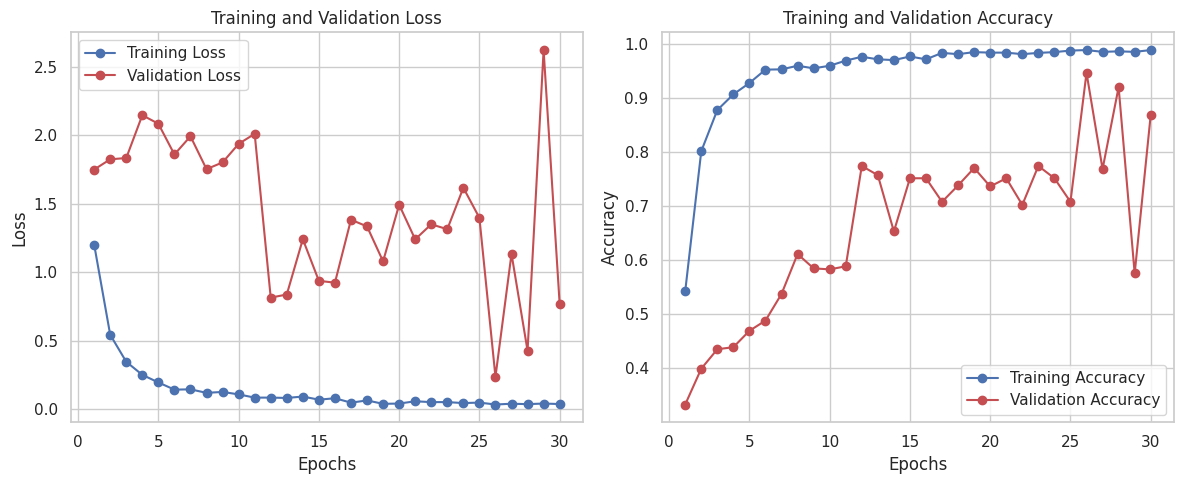

In [ ]:
def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure if save_dir and filename are provided
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        print(f"Plots saved as '{save_path}'")

    plt.show()
plot_loss_and_accuracy(history ,"/content/drive/MyDrive/SIH-Models/Rice", "train and loss" )



In [ ]:

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i in range(len(validation_generator)):
    true_labels = validation_generator[i][1]
    y_true.extend(true_labels)

    preds = model.predict(validation_generator[i][0])

    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true = np.argmax(y_true , axis = 1)

In [ ]:
class_names

['bacterial_leaf_blight',
 'brown_spot',
 'healthy',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

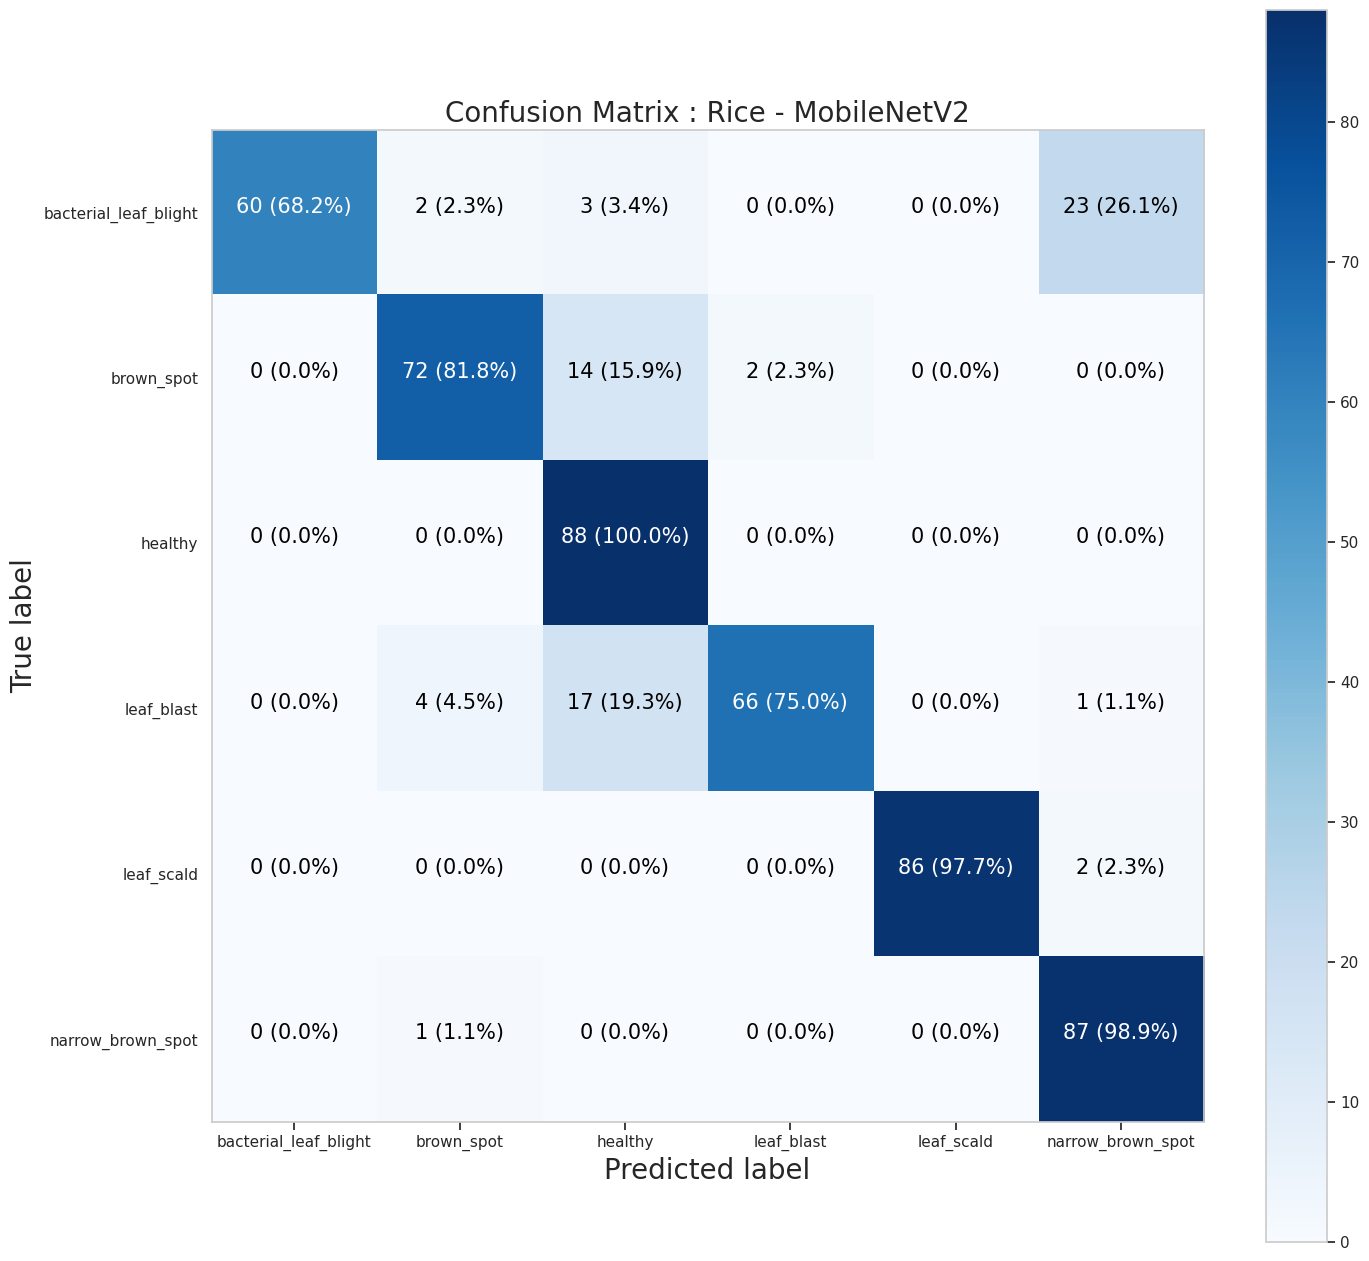

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (16, 16)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred )
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Rice - MobileNetV2",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

threshold = (cm.max() + cm.min()) / 2.

plt.grid(False)

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Rice/Model-CM')


In [ ]:

from sklearn.metrics import classification_report

print(classification_report(y_true , y_pred))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        88
           1       0.91      0.82      0.86        88
           2       0.72      1.00      0.84        88
           3       0.97      0.75      0.85        88
           4       1.00      0.98      0.99        88
           5       0.77      0.99      0.87        88

    accuracy                           0.87       528
   macro avg       0.90      0.87      0.87       528
weighted avg       0.90      0.87      0.87       528



In [ ]:
# Convert the Keras model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/SIH-Models/Rice/rice_mobilenetv2.tflite', 'wb') as f:
    f.write(tflite_model)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/SIH-Models/Rice/rice_mobilenetv2.tflite')
interpreter.allocate_tensors()

# Quantization using float16
converter_float16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_float16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_float16.target_spec.supported_types = [tf.float16]
tflite_model_float16 = converter_float16.convert()

# Save the float16 quantized TFLite model
with open('/content/drive/MyDrive/SIH-Models/Rice/rice_mobilenetv2_float16.tflite', 'wb') as f:
    f.write(tflite_model_float16)

In [ ]:
# Initialize lists to store test images and labels
test_imgs = []
test_labels = []

# Loop through the test generator to collect images and labels
for _ in range(len(validation_generator)):
    batch = validation_generator.next()  # Get the next batch from the iterator
    batch_images, batch_labels = batch  # Extract images and labels from the batch

    # Append the batch of images and labels to the respective lists
    test_imgs.extend(batch_images)
    test_labels.extend(batch_labels)

# Convert the lists to NumPy arrays
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

In [ ]:
TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/SIH-Models/Rice/rice_mobilenetv2_float16.tflite"


In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 6]
Output Type: <class 'numpy.float32'>


In [ ]:

interpreter.resize_tensor_input(input_details[0]['index'], (528, 224,224,3))
interpreter.resize_tensor_input(output_details[0]['index'], (528,6))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [528 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [528   6]
Output Type: <class 'numpy.float32'>


In [ ]:

interpreter.set_tensor(input_details[0]['index'], test_imgs)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (528, 6)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_labels , axis=1) , prediction_classes))

              precision    recall  f1-score   support

           0       1.00      0.69      0.82        88
           1       0.91      0.82      0.86        88
           2       0.72      1.00      0.84        88
           3       0.97      0.75      0.85        88
           4       1.00      0.98      0.99        88
           5       0.78      0.99      0.87        88

    accuracy                           0.87       528
   macro avg       0.90      0.87      0.87       528
weighted avg       0.90      0.87      0.87       528



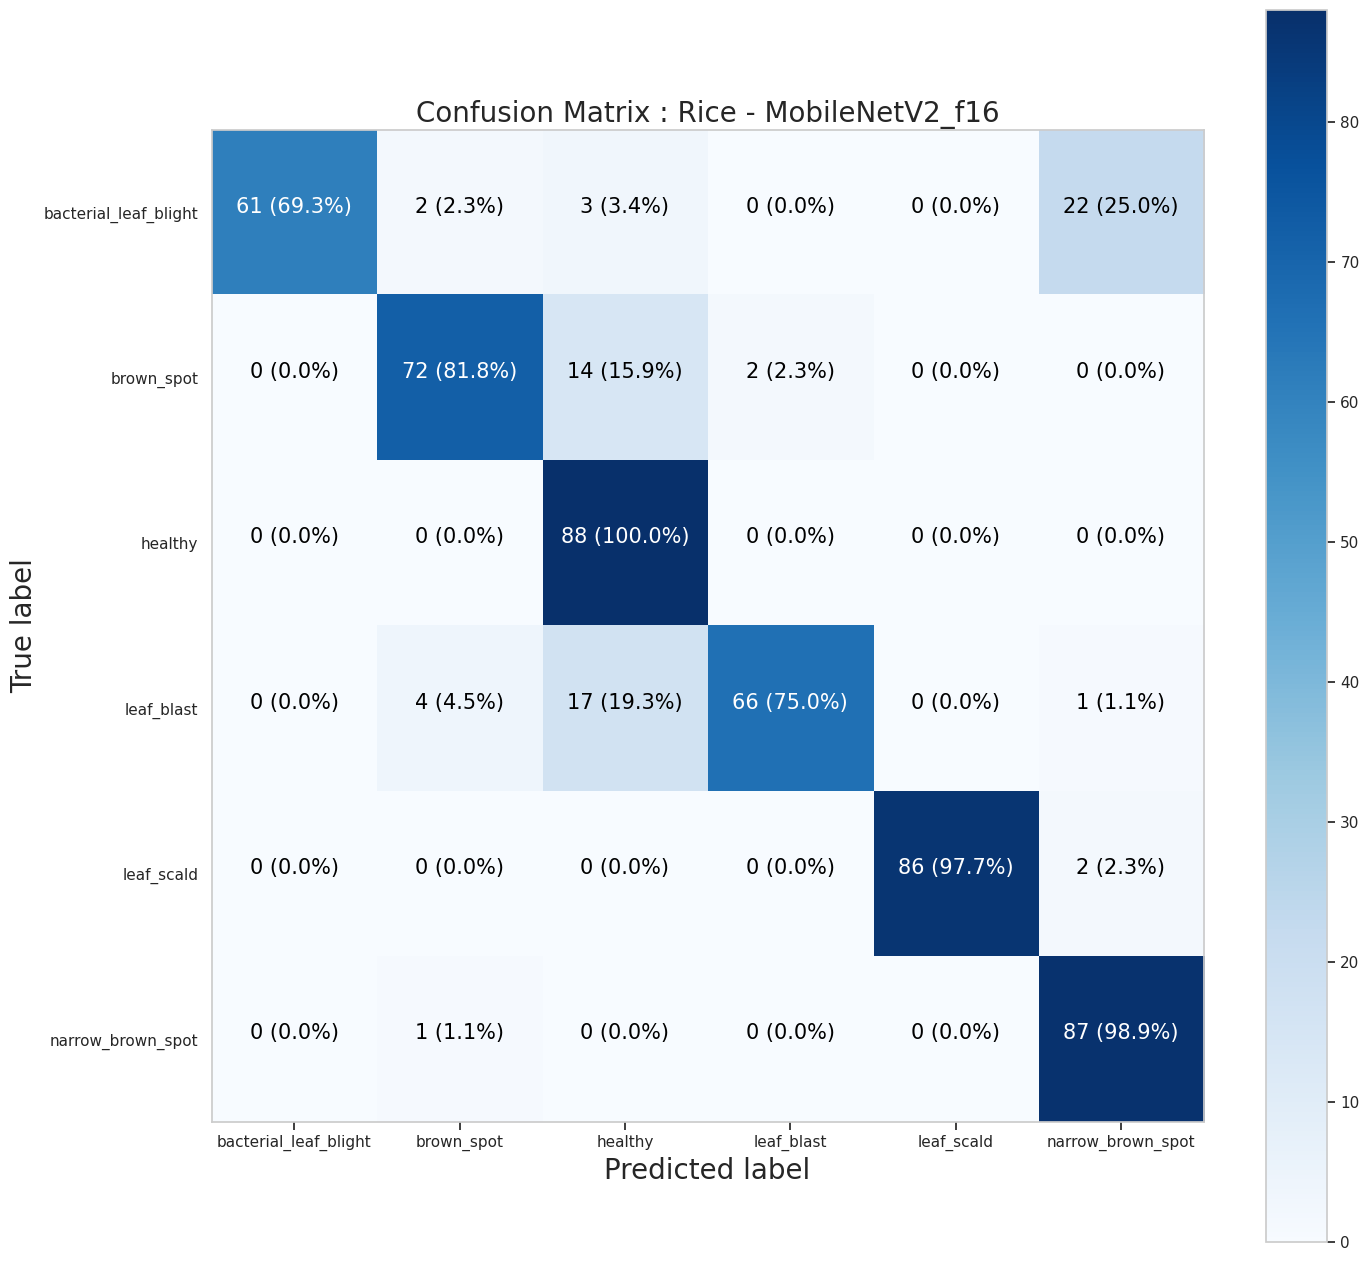

In [ ]:
figsize = (16, 16)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_labels , axis=1) , prediction_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Rice - MobileNetV2_f16",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

threshold = (cm.max() + cm.min()) / 2.
plt.grid(False)
# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Rice/Modelfloat16-CM')




### INT8 Qauntized Model

In [ ]:
# Load your trained Keras model in .h5 format
keras_model = load_model("/content/drive/MyDrive/SIH-Models/Rice/rice_mobilenetv2.h5")  # Replace with your model path

# Create the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]


generator = Val_gen.flow_from_directory(
    val_data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

num_calibration_steps = 100
def representative_data_gen():
    for batch_idx in range(num_calibration_steps):
        batch = generator.next()  # Get the next batch
        yield [batch[0]]  # Yield the batch inputs

# Set the representative dataset using the generator function
converter.representative_dataset = representative_data_gen

# Convert the model to quantized TFLite format
tflite_model_quantized = converter.convert()

# Save the quantized TFLite model
with open('/content/drive/MyDrive/SIH-Models/Rice/rice_mobilenetv2_int8.tflite', 'wb') as f:
    f.write(tflite_model_quantized)

Found 528 images belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:

TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/SIH-Models/Rice/rice_mobilenetv2_int8.tflite"


In [ ]:


interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 6]
Output Type: <class 'numpy.float32'>


In [ ]:

interpreter.resize_tensor_input(input_details[0]['index'], (528, 224,224,3 ))
interpreter.resize_tensor_input(output_details[0]['index'], (528, 6))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [528 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [528   6]
Output Type: <class 'numpy.float32'>


In [ ]:
interpreter.set_tensor(input_details[0]['index'], test_imgs)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (528, 6)


In [ ]:
print(classification_report(np.argmax(test_labels , axis=1) , prediction_classes))


              precision    recall  f1-score   support

           0       1.00      0.73      0.84        88
           1       0.97      0.83      0.90        88
           2       0.84      1.00      0.91        88
           3       0.78      0.93      0.85        88
           4       0.99      0.97      0.98        88
           5       0.95      1.00      0.97        88

    accuracy                           0.91       528
   macro avg       0.92      0.91      0.91       528
weighted avg       0.92      0.91      0.91       528



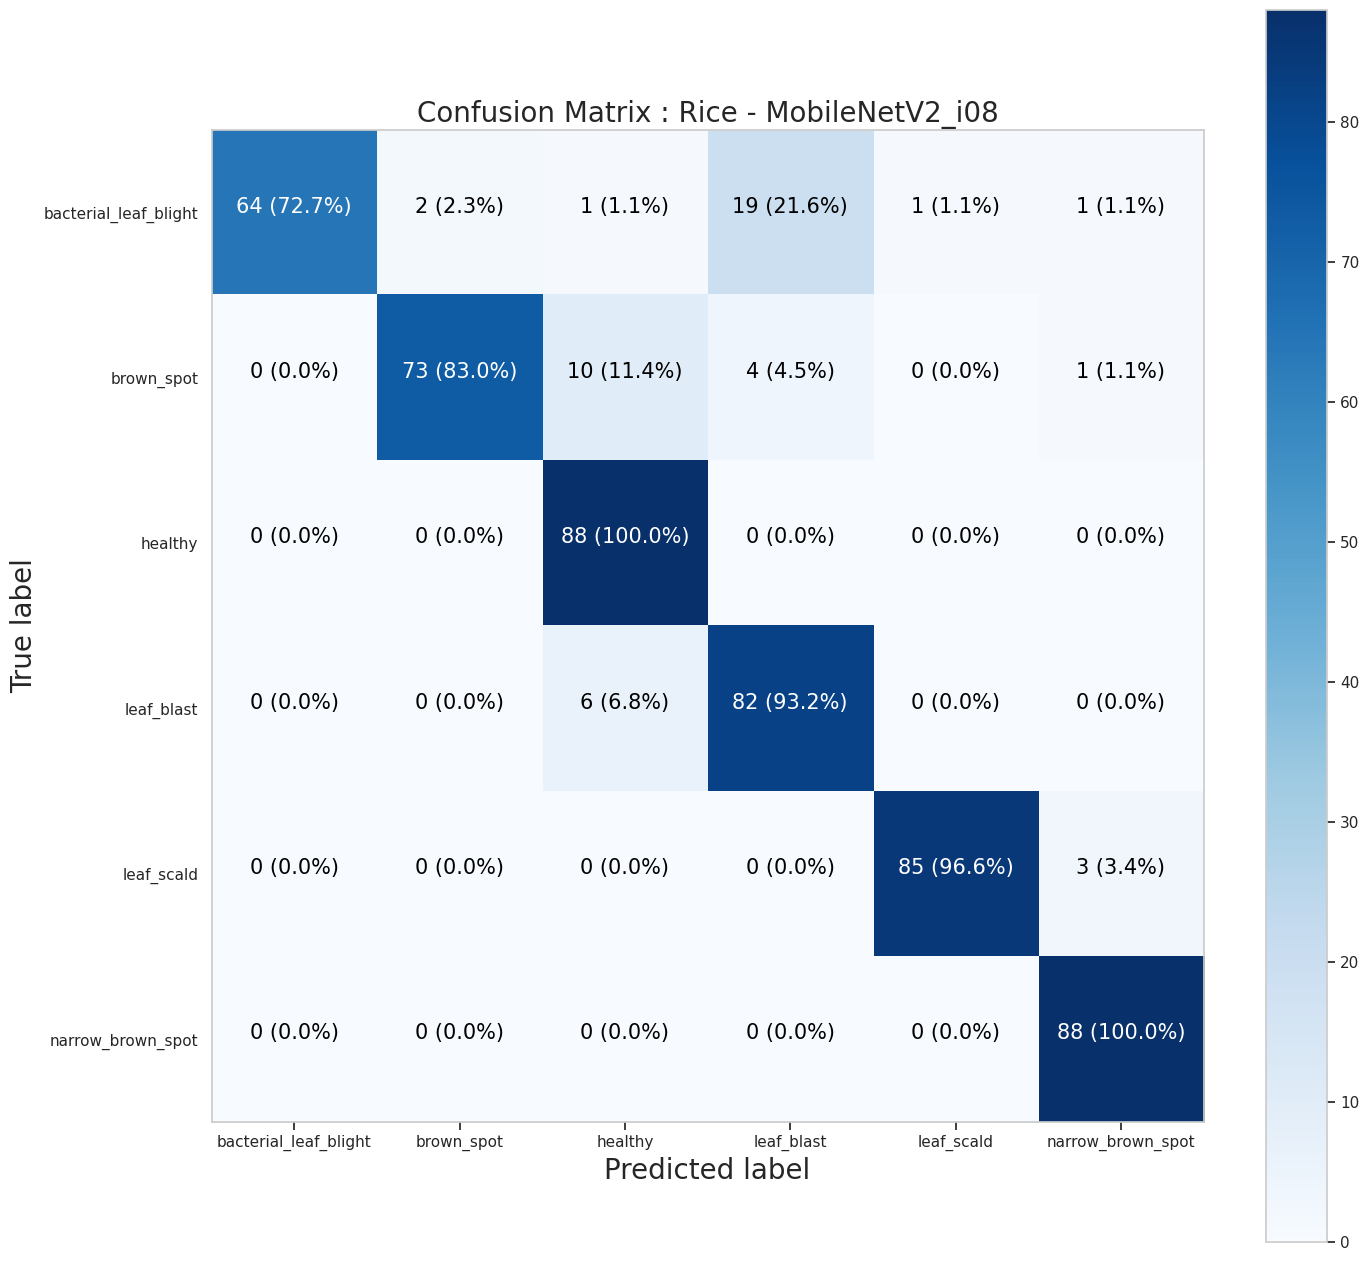

In [ ]:
figsize = (16, 16)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_labels , axis=1) , prediction_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Rice - MobileNetV2_i08",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

threshold = (cm.max() + cm.min()) / 2.
plt.grid(False)
# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Rice/ModelInt8-CM')




---